# Imports

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Dataset

In [8]:
df = pd.read_csv('https://gist.githubusercontent.com/tnpb-1st/ec2a10f0b5b0fb3612e753d1af76907e/raw/211a0275f5341fe92ad3aafd4c933afec9df36fa/mental-health.csv')
processed_df = pd.read_csv('https://gist.githubusercontent.com/tnpb-1st/ec2a10f0b5b0fb3612e753d1af76907e/raw/b41ef9244a9eb8756e58a35c79e74011483a62e4/mental-helth-processed.csv')

In [9]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [10]:
print(processed_df.head())
print('='*50)
print(processed_df['status'].value_counts())
print('='*50)
print(processed_df.shape)

                                           statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

                                 processed_statement  
0                                            oh gosh  
1       troubl sleep confus mind restless heart tune  
2  wrong back dear forward doubt stay restless re...  
3                  shift focu someth els still worri  
4                   restless restless month boy mean  
status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64
(52681, 3)


In [11]:
# Removing the unnamed column and the null value rows
df.drop(columns=['Unnamed: 0'], inplace=True)
df.dropna(subset=['statement'], inplace=True)

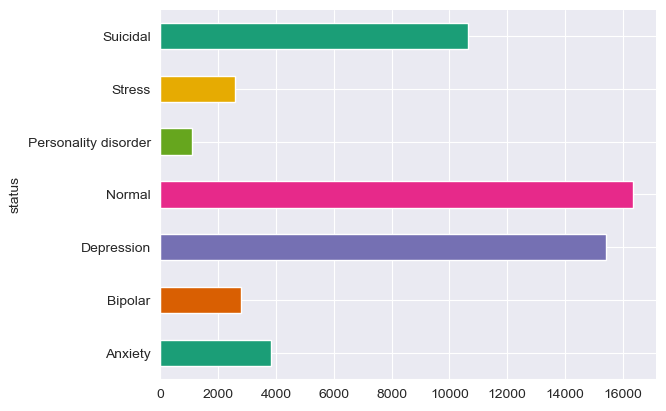

In [12]:
df.groupby('status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
df['status'].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

# Processamento dos Dados

In [14]:
# Baixa os dados necessários do NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Define a função para pré-processar o texto
def preprocess_text(text):
    # Converte o texto para minúsculas e o tokeniza (separa em palavras)
    tokens = word_tokenize(text.lower())

    # Remove tokens que não são alfanuméricos (mantém apenas palavras e números)
    tokens = [word for word in tokens if word.isalnum()]

    # Remove stop words (palavras comuns que não adicionam muito significado, como "e", "o", "a", etc.)
    tokens = [word for word in tokens if word not in stopwords.words('english')]

    # Cria um objeto do tipo PorterStemmer para realizar stemming
    stemmer = PorterStemmer()
    # Aplica stemming a cada token (reduz as palavras à sua raiz)
    tokens = [stemmer.stem(word) for word in tokens]

    # Junta os tokens processados de volta em uma string, com espaços entre eles
    preprocessed_text = ' '.join(tokens)

    # Retorna o texto pré-processado
    return preprocessed_text

[nltk_data] Downloading package punkt to /home/tnpb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tnpb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Aplica a função de pré-processamento à coluna 'statement' de um DataFrame
# df['processed_statement'] = df['statement'].apply(preprocess_text)

# Imprime as primeiras linhas do DataFrame com as colunas 'statement' e 'processed_statement'
# print(df[['statement', 'processed_statement']].head())

In [16]:
df = processed_df.dropna()

In [17]:
print(df[['statement', 'processed_statement']].head())

                                           statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   

                                 processed_statement  
0                                            oh gosh  
1       troubl sleep confus mind restless heart tune  
2  wrong back dear forward doubt stay restless re...  
3                  shift focu someth els still worri  
4                   restless restless month boy mean  


In [18]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['processed_statement'])
y = df['status']

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (52493, 5000)
Shape of y: (52493,)


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52493 entries, 0 to 52680
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   statement            52493 non-null  object
 1   status               52493 non-null  object
 2   processed_statement  52493 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Classifier

In [ ]:
svm_classifier = SVC(kernel='linear', random_state=42)

In [ ]:
svm_classifier.fit(X_train, y_train)

In [ ]:
y_pred = svm_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

# RNN

In [21]:
# Extrai as features e os labels
texts = df['processed_statement'].values
labels = df['status'].values

# Converte os labels para formato numérico
label_mapping = {
    'Normal': 0, 'Depression': 1, 'Suicidal': 2,
    'Anxiety': 3, 'Bipolar': 4, 'Stress': 5, 'Personality disorder': 6
}
labels = np.array([label_mapping[label] for label in labels])

# Divide os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokeniza o texto
tokenizer = Tokenizer(num_words=10000)  # Usando as 10.000 palavras mais frequentes
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Preenche as sequências para garantir tamanho uniforme
max_sequence_length = 100  # Pode ser ajustado
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Converte os labels para categórico
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [27]:
# Define o modelo
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_sequence_length))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, use_cdn='auto'))
model.add(Dense(7, activation='softmax'))  # 7 classes

# Compila o modelo
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Exibe o resumo do modelo
model.summary()

TypeError: ('Keyword argument not understood:', 'use_cdn')

In [25]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint('best_model_weights.keras',
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      mode='max',  # or 'max' depending on the metric
                                      verbose=1)


In [26]:
# Example training code with ModelCheckpoint callback
history = model.fit(X_train_pad, y_train_cat,
                    batch_size=32,
                    epochs=6,
                    validation_data=(X_test_pad, y_test_cat),
                    callbacks=[checkpoint_callback])


Epoch 1/6
  35/1313 [..............................] - ETA: 13:01 - loss: 1.5981 - accuracy: 0.4170

KeyboardInterrupt: 

In [ ]:
# Avalia o modelo
score, acc = model.evaluate(X_test_pad, y_test_cat, batch_size=32)

print('Pontuação do teste:', score)
print('Acurácia do teste:', acc)

# Obter previsões para os dados de teste
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Gerar o relatório de classificação
report = classification_report(y_true, y_pred, target_names=label_mapping.keys())
print(report)

In [ ]:
model.save_weights('meu_modelo_pesos.weights.h5')

# LRP

# Lime